### Autor: Alexis Castillo
### Script para el entrenamiento del modelo

In [ ]:
# Conexion a Google Colaborative
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
# Librerías a instalar.
# !pip install pycaret
# !pip install optuna

In [ ]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from collections import Counter
from imblearn.combine import SMOTETomek
from pycaret.classification import *

In [ ]:
# Carga de datos desde una carpeta en google drive
# Dataset armado para entrada a los algoritmos (Estos aún no están normalizados)
train_preprared = pd.read_csv('/gdrive/MyDrive/entrenamiento_intercorp/train_pre_normalize.csv')
train_preprared.head(2)

,EDAD,INGRESO_ESTIMADO,Target,FLGSEXO_M,TIPESTCIVIL_CAS,TIPESTCIVIL_CBS,TIPESTCIVIL_CON,TIPESTCIVIL_SEP,TIPESTCIVIL_SOL,TIPESTCIVIL_VIU,...,SEGMENTO_BANCO_SEG_10,SEGMENTO_BANCO_SEG_11,SEGMENTO_BANCO_SEG_2,SEGMENTO_BANCO_SEG_3,SEGMENTO_BANCO_SEG_4,SEGMENTO_BANCO_SEG_5,SEGMENTO_BANCO_SEG_6,SEGMENTO_BANCO_SEG_7,SEGMENTO_BANCO_SEG_8,SEGMENTO_BANCO_SIN_SEG
0,34.0,750.780,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,25.0,2898.245,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
train_preprared.shape

(135247, 50)

In [ ]:
# Separo datos de variables predictoras y la variable independiente
X = train_preprared.drop('Target', axis=1)
y = train_preprared.Target

In [ ]:
# Escalamiento de variables numéricos
# Algunos algoritmos son sensibles a la escala de los datos, 
# otros como los basados en árboles de decisión no lo son pero ayuda a que el entrenamiento converga más rápido
X_num = X[['EDAD','INGRESO_ESTIMADO']]

scaler = StandardScaler()
train_scaled_X = scaler.fit_transform(X_num)

X_num_scaled = pd.DataFrame(train_scaled_X, 
                            columns=X_num.columns, 
                            index=X.index)

X_num_scaled.describe()

,EDAD,INGRESO_ESTIMADO
count,1.352470e+05,1.352470e+05
mean,2.823583e-16,3.638165e-16
std,1.000004e+00,1.000004e+00
min,-2.149727e+00,-1.223115e+00
25%,-7.912837e-01,-7.558280e-01
50%,-1.643098e-01,-3.537761e-01
75%,5.671597e-01,4.508216e-01
max,2.604825e+00,2.302270e+00


In [ ]:
# Vuelvo a definir el dataset de variables independientes con los datos escalados
X = pd.concat([X.drop(['EDAD','INGRESO_ESTIMADO'], axis=1), X_num_scaled], axis=1)

### Muestreo

In [ ]:
# Creación de la data de train y la data de test estratificado por el target
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    test_size=0.20,
                                                    stratify= y,
                                                    random_state=123)

# Realizo el reset index antes de aplicar el resampling de la base de entrenamiento
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

Balance de clases de la variable a predecir (Target)

In [ ]:
# Visualizando la variable target
print("\nCantidad de elementos por Clase: ")
target_count = train_preprared['Target'].value_counts()

print('Clase 0:', target_count[0], "({:.3%})".format(round(target_count[0] / (target_count[0]+target_count[1]), 2)))
print('Clase 1:', target_count[1], "({:.3%})".format(round(target_count[1] / (target_count[0]+target_count[1]), 2)))
print('Total  :', train_preprared.shape[0])


Cantidad de elementos por Clase: 
Clase 0: 134949 (100.000%)
Clase 1: 298 (0.000%)
Total  : 135247


In [ ]:
# Aplico una técnica de remuestreo de la base de entrenamiento
# SMOTETomek: Realiza un sobremuestreo de la clase  minoritaria y elimina registros de la clase mayoritaria, para ambas técnicas utiliza un criterio matemático
# El parámetro sampling_strategy indica la proporción final a la que debe terminar el sobremuestreo, en este caso hasta una proporción de 95% a 5%.
st_overunder = SMOTETomek(sampling_strategy=0.05, 
                          random_state=123)
X_st_overunder, y_st_overunder = st_overunder.fit_resample(X_train, y_train)
print ("Distribución de clases antes del resampling {}".format(Counter(y_train)))
print ("Distribución de clases después del resampling {}".format(Counter(y_st_overunder)))

Distribución de clases antes del resampling Counter({0: 107959, 1: 238})
Distribución de clases después del resampling Counter({0: 107791, 1: 5229})


In [ ]:
# Nuevo dataset con el remuestreo de clases.
train_prep = pd.concat([X_st_overunder, y_st_overunder], axis=1)

In [ ]:
train_prep.shape

(113020, 50)

# Etapa 4: Entrenamiento de los algoritmos de clasificación
Para tener un primer bench de los algoritmos que potencialmente podrían funcionar mejor con los datos, utlizo la herramienta de AutoML Pycaret para probar 15 algoritmos de clasificación y tunear posteriormente solo los mejores.

Instaciamos los datos para las pruebas de algoritmos con pycaret

In [ ]:
clf1 = setup(train_prep, 
             target='Target', 
             session_id=123, 
             fold_strategy='stratifiedkfold', 
             fold=6)

,Description,Value
0,Session id,123
1,Target,Target
2,Target type,Binary
3,Original data shape,"(113020, 50)"
4,Transformed data shape,"(113020, 50)"
5,Transformed train set shape,"(79114, 50)"
6,Transformed test set shape,"(33906, 50)"
7,Numeric features,49
8,Preprocess,True
9,Imputation type,simple


In [ ]:
# La librería pycaret entrena distintos algoritmos de clasificación y nos indica cuál es el que genera las mejores métricas
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.9936,0.9928,0.8626,0.9978,0.9251,0.9218,0.9245,25.9017
lightgbm,Light Gradient Boosting Machine,0.9930,0.9920,0.8495,0.9994,0.9182,0.9146,0.9180,1.9167
et,Extra Trees Classifier,0.9913,0.9889,0.8544,0.9531,0.9010,0.8964,0.8979,13.1600
rf,Random Forest Classifier,0.9895,0.9908,0.8093,0.9580,0.8773,0.8719,0.8753,10.5517
lda,Linear Discriminant Analysis,0.9828,0.9490,0.6279,1.0000,0.7713,0.7628,0.7853,1.2167
svm,SVM - Linear Kernel,0.9827,0.0000,0.6279,0.9969,0.7704,0.7619,0.7840,0.4550
knn,K Neighbors Classifier,0.9822,0.9629,0.7803,0.8264,0.8026,0.7933,0.7937,17.9850
dt,Decision Tree Classifier,0.9816,0.8863,0.7773,0.8159,0.7960,0.7864,0.7867,0.6050
lr,Logistic Regression,0.9814,0.9549,0.5992,0.9991,0.7489,0.7399,0.7662,3.1250
ridge,Ridge Classifier,0.9808,0.0000,0.5847,1.0000,0.7377,0.7285,0.7570,0.2650


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='binary:logistic', predictor=None, ...)

Según los reultados de los algoritmos vemos que Xgboost es el algoritmo más prometedor a clasificar mejor el target. Procedo a tunear este algoritmo.
También podría probar lightgbm pero este funcionar de forma muy similar al Xgboost. Otra opción sería probar también el Extra Trees Classifier y Random Forest y realizar un ensamblado de modelos por votación soft de estos junto al Xgboost; sin embargo por ahora no lo realizo y solo probaré el Xgboost.

In [ ]:
# Función para graficar matriz de confusión y métricas
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, xticklabels=[0,1], yticklabels=[0,1], annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(y_test, pred_y))

Tuning del modelo Random Forest, tiene métricas aceptables aumque no las mejores.

Utilizo la librería optuna para las pruebas de los hiperparámetros y quedarnos con los mejores

In [ ]:
import optuna
from optuna.integration import OptunaSearchCV
from sklearn.model_selection import StratifiedKFold
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
def objective(trial, X, y, scoring):
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step = 100),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 3, 10),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "class_weight": trial.suggest_categorical("class_weight", ["balanced"])
    }

    cv = StratifiedKFold(n_splits=6, shuffle=True, random_state=123)

    cv_scores = np.empty(6)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = RandomForestClassifier(**param_grid)
        model.fit(
            X_train,
            y_train
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [ ]:
study = optuna.create_study(direction="maximize", study_name="RF Classifier")
func = lambda trial: objective(trial, pd.DataFrame(X_st_overunder), y_st_overunder, scoring = "auc")
study.optimize(func, n_trials=5)

In [ ]:
print(f"\tBest value (auc): {study.best_value:.5f}")
print(f"\tBest params:")
for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.59483
	Best params:
		n_estimators: 1000
		max_depth: 3
		min_samples_split: 8
		max_features: log2
		class_weight: balanced


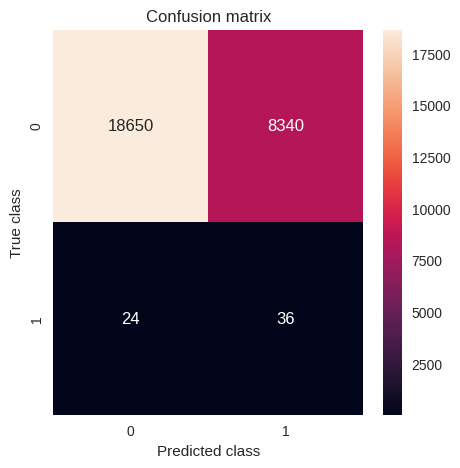

              precision    recall  f1-score   support

           0       1.00      0.69      0.82     26990
           1       0.00      0.60      0.01        60

    accuracy                           0.69     27050
   macro avg       0.50      0.65      0.41     27050
weighted avg       1.00      0.69      0.82     27050



,metric,train,test
0,AUC,0.811004,0.724997
1,Precision,0.105632,0.004298
2,Recall,0.747562,0.600000
3,f1-score,0.185107,0.008535


In [ ]:
# Entrenamiento del modelo Random Forest con los mejores hiperparámetros que nos dio optuna
from sklearn.ensemble import RandomForestClassifier
rf_model_base_optimo = RandomForestClassifier(n_estimators= 1000,
                                                   max_depth= 3,
                                                   min_samples_split= 8, 
                                                   max_features= 'log2',
                                                   class_weight= 'balanced',                                           
                                                   random_state=123)

rf_model_base_optimo.fit(X_st_overunder, y_st_overunder)

pred_y_train= rf_model_base_optimo.predict(X_st_overunder)
pred_y_test= rf_model_base_optimo.predict(X_test)
prob_train = rf_model_base_optimo.predict_proba(X_st_overunder)[:,1]
prob_test = rf_model_base_optimo.predict_proba(X_test)[:,1]

mostrar_resultados(y_test, pred_y_test)
metrics = pd.DataFrame({'metric':['AUC','Precision','Recall','f1-score'],
                                'train':[roc_auc_score(y_st_overunder, prob_train),
                                                precision_score(y_st_overunder,pred_y_train),
                                                recall_score(y_st_overunder,pred_y_train),
                                                f1_score(y_st_overunder,pred_y_train)],

                                'test':[roc_auc_score(y_test, prob_test),
                                               precision_score(y_test,pred_y_test),
                                               recall_score(y_test,pred_y_test),
                                               f1_score(y_test,pred_y_test)]})

metrics

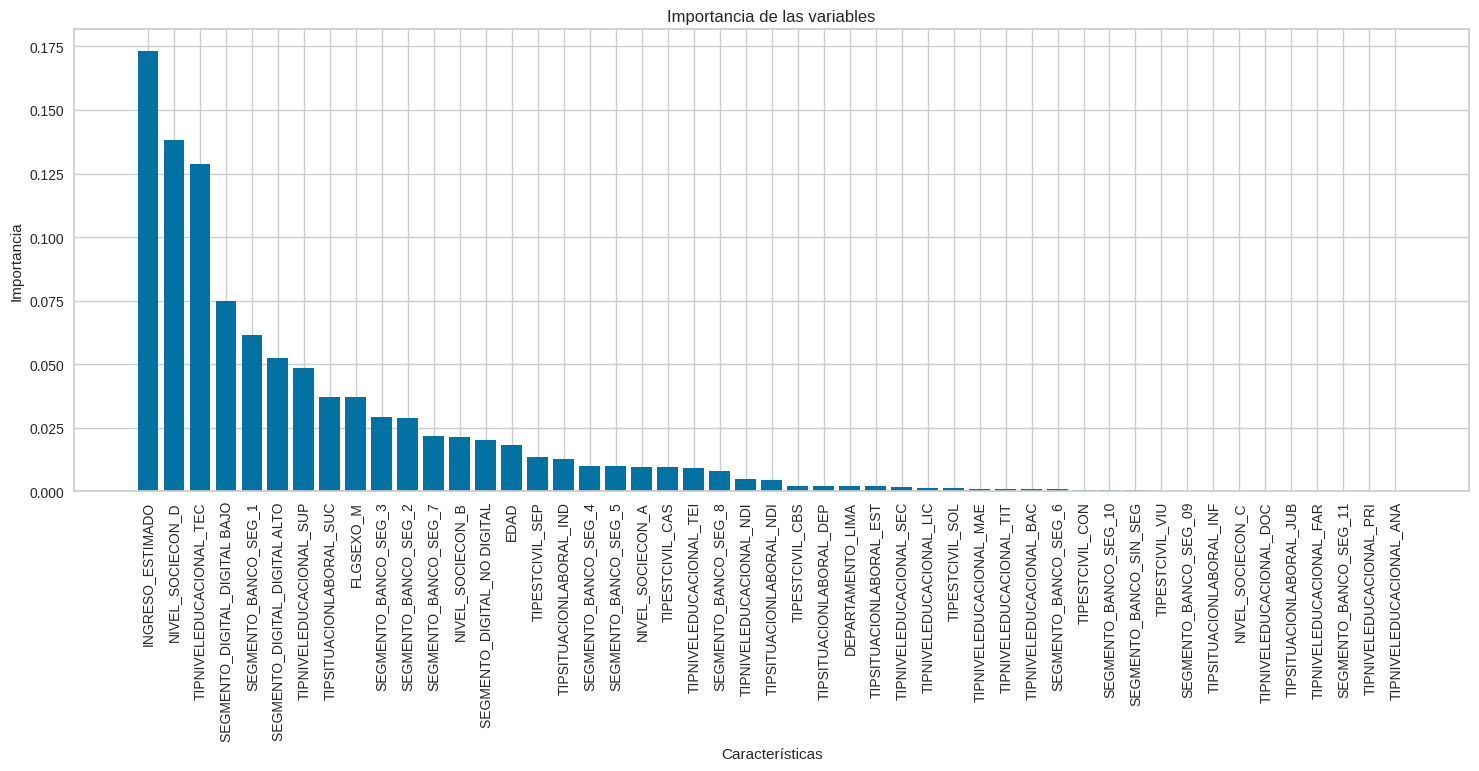

In [ ]:
# Gráfico de la importancia de las variables
plt.rcParams['figure.figsize']=(18,6)
importances = rf_model_base_optimo.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_st_overunder.columns
plt.figure()
plt.title("Importancia de las variables")
plt.bar(range(X_st_overunder.shape[1]), importances[indices])
plt.xticks(range(X_st_overunder.shape[1]), feature_names[indices])
plt.xticks(rotation=90)
plt.xlabel("Características")
plt.ylabel("Importancia")
plt.show()

### Conclusión: Se observa sobreajuste, podemos continuar iterando en el entrenamiento y tunear mejor los hiperparámetros o probar otros ensambles de modelos. Por ahora por limitación de tiempo lo dejo así.

Guardamos el modelo entrenado para el proceso de scoring en base de test que se reservó inicialmente

In [ ]:
# Guardo el modelo entrenado
import pickle

with open('/gdrive/MyDrive/entrenamiento_intercorp/modelo.pkl', 'wb') as archivo:
    pickle.dump(rf_model_base_optimo, archivo)

# Etapa 5: Sugerencias

## Conclusiones:
* El problema de desbalance de clases en la variable target genera deficiencias en los algoritmos, se trató de suavizar el error generando una nueva base bajo una técnica de resampling, esta mejora y logra predecir valores 1 del target.
* Las variables predictoras también presentan desbalance, se propone probar agrupamientos para mejorar esto y tener clases de variables mejor distribuidas.
* Realizar el tunning de los hiperparámetros del algoritmo es un proceso de prueba y error, con mayor dedicación se pueden obtener mejores resultados
* El proceso de decidir con qué métrica de éxito se va a medir la eficiencia del algoritmo queda a criterio del área de negocio en acuerdo con el desarrollador del modelo, en este caso se quiere priorizar que el modelo prediga mejor los casos de detección de realizar un depósito a plazo fijo por parte del cliente, podemos tener un margen de error para los casos de falsos positivos, los cuales son clientes que serán gestionados por predicción del modelo pero que en la realidad no están propensos a este depósito a plazo fijo. Con esto definido se puede sugerir la métrica de éxito adecuada según el contexto de negocio y capacidad de gestionamiento.